# Build an ML model on consumer loan data

In [1]:
# Load libraries
import os
import sys
import time
import pickle
import platform
import datetime
import pkg_resources
from pathlib import Path
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import seaborn
from matplotlib import pyplot

Path('../models').mkdir(parents=True, exist_ok=True)

In [2]:
start_time = time.time()

In [3]:
seed = 1
version = 1.0
model_identifier = 'loanapp'

## Load data

In [4]:
raw = pd.read_csv('https://raw.githubusercontent.com/sedeh/Datasets/main/loan_200k.csv')

## Display data

In [5]:
raw.shape

(200000, 18)

In [6]:
raw.columns.to_list()

['id',
 'member_id',
 'loan_amnt',
 'term_in_months',
 'interest_rate',
 'payment',
 'grade',
 'sub_grade',
 'employment_length',
 'home_owner',
 'income',
 'verified',
 'default',
 'purpose',
 'zip_code',
 'addr_state',
 'open_accts',
 'credit_debt']

In [7]:
raw.head()

,id,member_id,loan_amnt,term_in_months,interest_rate,payment,grade,sub_grade,employment_length,home_owner,income,verified,default,purpose,zip_code,addr_state,open_accts,credit_debt
0,123688,123685,1800,36,17.22,64.38,G,G3,1,0,1896.0,0,0,debt_consolidation,853xx,AZ,3,702
1,139940,139937,500,36,9.01,15.91,B,B2,1,0,2000.0,0,1,other,727xx,AR,2,0
2,288342,288338,500,36,8.00,15.67,A,A3,1,0,3300.0,0,1,educational,303xx,GA,3,0
3,228954,228911,1600,36,7.43,49.72,A,A2,1,0,3500.0,0,1,other,069xx,CT,2,506
4,267670,252052,1525,36,10.71,49.72,B,B5,1,0,3600.0,0,1,moving,109xx,NY,5,3757


The features are typical variables associated with a consumer loan application.

## Create a new feature

Convert a categorical feature, `grade`, to a continuous feature using target encoding which you can read about in my article here: https://www.linkedin.com/pulse/one-hot-vs-target-encoding-samuel-edeh/

In [8]:
means = raw[['grade', 'interest_rate']].groupby('grade').mean().reset_index()
keys = means['grade']
values = means.interest_rate
mapper = {keys[i]: values[i] for i in range(len(keys))}
raw['interest_rate_by_grade'] = raw['grade'].map(mapper)

## Filter data

Drop grade and id columns. In a future iteration, you could attempt to incorporate these features. Ideally, no data should be left behind.

In [9]:
data = raw.drop(['grade', 'id', 'member_id', 'sub_grade', 'purpose', 'addr_state', 'zip_code'], axis=1)

In [10]:
features = data.columns.to_list()
features.remove('interest_rate')

## Check for outliers

In [11]:
data.describe()

,loan_amnt,term_in_months,interest_rate,payment,employment_length,home_owner,income,verified,default,open_accts,credit_debt,interest_rate_by_grade
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,2.000000e+05,200000.000000
mean,13839.481750,41.948520,13.982023,423.007093,5.971780,0.511585,7.218162e+04,0.448440,0.133875,10.741955,1.618117e+04,13.982023
std,8088.791755,10.362438,4.383974,240.924297,3.455486,0.499867,5.586973e+04,0.497336,0.340519,4.663660,2.065942e+04,4.151325
min,500.000000,36.000000,5.420000,15.670000,1.000000,0.000000,1.896000e+03,0.000000,0.000000,0.000000,0.000000e+00,7.607718
25%,7800.000000,36.000000,10.990000,247.617500,3.000000,0.000000,4.500000e+04,0.000000,0.000000,7.000000,6.510000e+03,11.715400
50%,12000.000000,36.000000,13.680000,375.490000,6.000000,1.000000,6.200000e+04,0.000000,0.000000,10.000000,1.191650e+04,15.199209
75%,19400.000000,36.000000,16.990000,555.990000,10.000000,1.000000,8.640000e+04,1.000000,0.000000,13.000000,2.038500e+04,18.054771
max,35000.000000,60.000000,26.060000,1408.130000,10.000000,1.000000,7.141778e+06,1.000000,1.000000,62.000000,2.568995e+06,23.706543


Looking at the `max`, we don't see outliers we should be concerned about.

## Check for collinearity

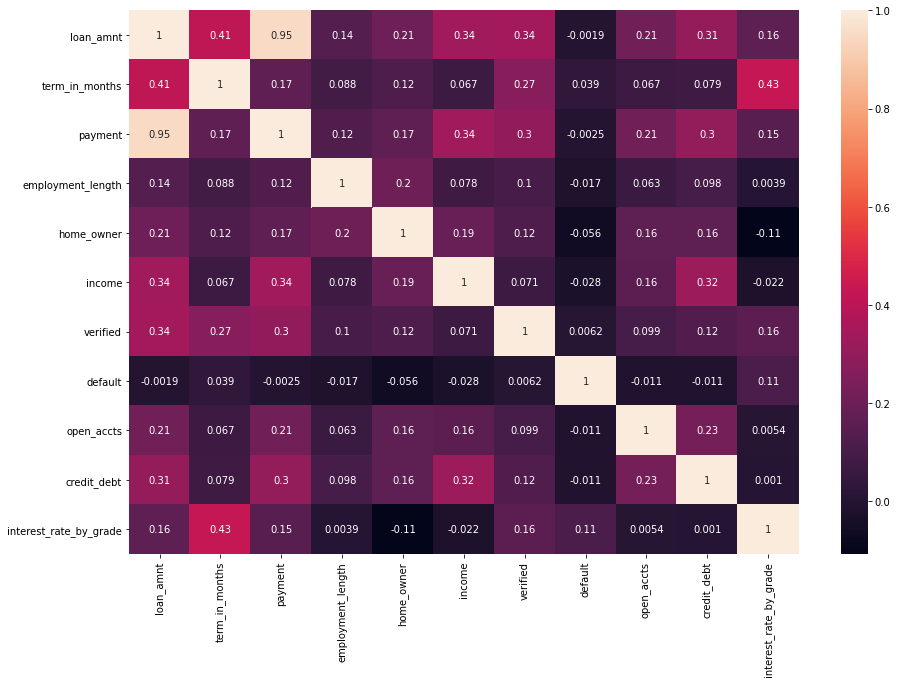

In [12]:
pyplot.figure(figsize=(15, 10))
seaborn.heatmap(data[features].corr(), annot=True)
pyplot.show()

`loan_amnt` is strongly correlated with `payment`. This makes sense because the bigger the loan the bigger your payment. However, if two features have more than 98% correlation then they more or less provide the same information to the model. In that case, you can drop one of the features (the one least correlated with the target). Eliminating a redundant feature helps to keep the model simple (Occam's razor) and can help a model to generalize.

In [13]:
features

['loan_amnt',
 'term_in_months',
 'payment',
 'employment_length',
 'home_owner',
 'income',
 'verified',
 'default',
 'open_accts',
 'credit_debt',
 'interest_rate_by_grade']

In [14]:
X = data[features]
y = data['interest_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
print('X_train.shape: ', X_train.shape)
print('X_test.shape: ', X_test.shape)
model = RandomForestRegressor(random_state=seed)
# model = GradientBoostingRegressor(random_state=seed)
# model = XGBRegressor(random_state=seed)
model.fit(X_train, y_train)
y_true = model.predict(X_test)
mean_absolute_error(y_true, y_test)

X_train.shape:  (180000, 11)
X_test.shape:  (20000, 11)


0.19214635500000524

I prefer ensemble algorithms and those are what I tried above. Ensemble method is a machine learning technique that combines several base models in order to produce a super model. In essense, weak models work together to blur individual weaknesses and create a superstructure with enhanced capability.

`RandomForestRegressor` achieved an MAE of 0.1921 out-performing other ensemble algorithms specifically `XGBRegressor` (MAE 0.4728) and `GradientBoostingRegressor` (MAE 1.0080). This means that on average we predicted the interest rates to within 0.19 percent. That's substantial given that interest rates range from 5.42 to 26.06. All that by using the default algorithm setting without hyperparamater tuning. You could try to tune the hyperparameters and see if you improve on this result. 

## <font color='green'>Optional</font>

To try out `XGBRegressor`, you would need to install `xgboost`. On the command line, execute:

```
conda activate loanapp
pip install xgboost
```

And perhaps work through gcc installation issues. Restart the notebook server and now you should have `xgboost`.

## Save model

Embed information about the training environment to define the model's specs and help with any future troubleshooting.

In [15]:
model.version = version
model.model_identifier = model_identifier
model.created_date = str(datetime.datetime.now())
model.git_hash = os.popen('git rev-parse HEAD').read().strip()

In [16]:
environment = dict()
environment['python_version'] = sys.version
environment['python_implementation'] = sys.implementation.name
environment['platform_version'] = platform.version()
environment.update(dict(tuple(str(ws).split()) for ws in pkg_resources.working_set))
model.environment = environment

In [17]:
with open(f'../models/{model_identifier}.pkl', 'wb') as output_file:
    pickle.dump(model, output_file)

In [18]:
f'Runtime: {round(time.time() - start_time)} sec'

'Runtime: 80 sec'